In [40]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import odeint
from sympy.abc import phi, theta, omega
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
from IPython.display import HTML

%matplotlib inline
init_printing() 

In [2]:
m_1, m_2, g, t, L_1, L_2, theta_1, theta_2, theta_1_d, theta_2_d = sp.symbols("m_1 m_2 g t L_1 L_2 theta_1 theta_2 omega_1 omega_2")
theta_1 = theta_1(t)
theta_2 = theta_2(t)

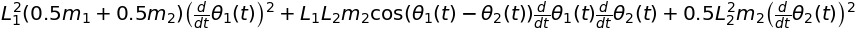

In [3]:
T = (
    0.5 * (m_1 + m_2) * L_1**2 * theta_1.diff(t)**2 + 
    m_2 * L_1 * L_2 * theta_1.diff(t) * theta_2.diff(t) * sp.cos(theta_1 - theta_2) + 
    0.5 * m_2 * L_2 **2 * theta_2.diff(t)**2
    )

T

In [4]:
Q_1 = -(m_1 + m_2) * g * L_1 * sp.sin(theta_1)
Q_2 = -m_2 * g * L_2 * sp.sin(theta_2)

In [5]:
eq1 = T.diff(theta_1.diff(t)).diff(t) - T.diff(theta_1) - Q_1

In [6]:
eq2 = T.diff(theta_2.diff(t)).diff(t) - T.diff(theta_2) - Q_2

In [7]:
sols = sp.solve([eq1, eq2], [theta_1.diff(t, t), theta_2.diff(t, t)])
keys = []
for key in sols:
    keys.append(key)

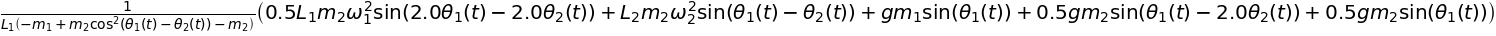

In [10]:
theta_1_dd = sols[keys[0]].subs({theta_1.diff(t):theta_1_d, theta_2.diff(t):theta_2_d})
theta_1_dd

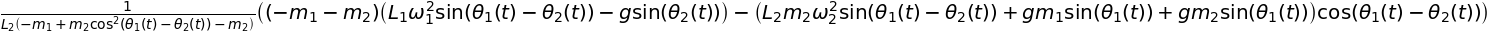

In [15]:
theta_2_dd = sols[keys[1]].subs({theta_1.diff(t):theta_1_d, theta_2.diff(t):theta_2_d})
theta_2_dd

In [16]:
theta_1_dd_f = lambdify(
    (m_1, m_2, g, L_1, L_2, theta_1, theta_2, theta_1_d, theta_2_d), 
    theta_1_dd, 'numpy')

In [18]:
theta_2_dd_f = lambdify(
    (m_1, m_2, g, L_1, L_2, theta_1, theta_2, theta_1_d, theta_2_d), 
    theta_2_dd, 'numpy')

In [20]:
def double_pendulum(X, t, m_1, m_2, g, L_1, L_2):
    theta_1_d, theta_2_d, theta_1, theta_2 = X
    theta_1_dd = theta_1_dd_f(m_1, m_2, g, L_1, L_2, theta_1, theta_2, theta_1_d, theta_2_d)
    theta_2_dd = theta_2_dd_f(m_1, m_2, g, L_1, L_2, theta_1, theta_2, theta_1_d, theta_2_d)
    return [theta_1_dd, theta_2_dd, theta_1_d, theta_2_d]

In [73]:
X_0 = [0, 0, np.pi/2, np.pi/4]
dt = 0.01
var_t = np.arange(0, 100, dt) 
steps = len(var_t)
var_m_1 = 2.0
var_m_2 = 1.0
var_L_1 = 1.0
var_L_2 = 2.0
var_g = -9.81
sol = odeint(double_pendulum, X_0, var_t, args=(var_m_1, var_m_2, var_g, var_L_1, var_L_2))
sim_theta_1_d = sol[:, 0]
sim_theta_2_d = sol[:, 1]
sim_theta_1 = sol[:, 2]
sim_theta_2 = sol[:, 3]

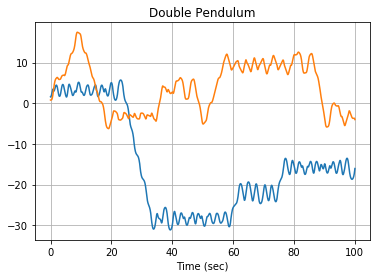

In [74]:
plt.plot(var_t, sim_theta_1)
plt.plot(var_t, sim_theta_2)
plt.grid()
plt.title("Double Pendulum")
plt.xlabel("Time (sec)")

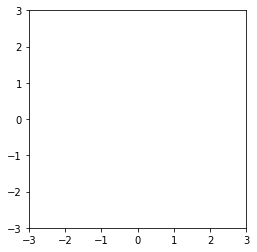

In [77]:
fps = 25.0
interval = 1000/fps
a_step = np.floor(1/fps/dt)
plot_ix = np.arange(0, steps, a_step).astype(int)
ix_range = plot_ix.shape[0]
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,  xlim=(-3, 3), ylim=(-3, 3))
line, = ax.plot([], [], 'o-', lw=2)

def init():
    line.set_data([], [])
    
def animate(i, sim_theta_1, sim_theta_2, L_1, L_2):
    x1 = np.sin(sim_theta_1[i]) * L_1
    y1 = np.cos(sim_theta_1[i]) * L_1
    x2 = x1 + np.sin(sim_theta_2[i]) * L_2
    y2 = y1 + np.cos(sim_theta_2[i]) * L_2
    line.set_data([0, x1, x2], [0, y1, y2])
    return line

ani = animation.FuncAnimation(fig, animate, ix_range,
                              interval=interval, blit=False, fargs=(sim_theta_1[plot_ix], sim_theta_2[plot_ix], var_L_1, var_L_2),
                              init_func=init)
HTML(ani.to_html5_video())